In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import os
import tarfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2

tf.config.run_functions_eagerly(True)
# Extract the dataset
dataset_path = '/kaggle/input/final-project-soc-23b2507/CUB_200_2011.tgz'
extract_path = '/kaggle/extracted/CUB_200_2011'

with tarfile.open(dataset_path, 'r:gz') as tar:
    tar.extractall(extract_path)

# Load the data
images_path = os.path.join(extract_path, 'CUB_200_2011', 'images')
images_list = []
labels_list = []

with open(os.path.join(extract_path, 'CUB_200_2011', 'images.txt')) as f:
    for line in f:
        images_list.append(line.strip().split(' ')[1])

with open(os.path.join(extract_path, 'CUB_200_2011', 'image_class_labels.txt')) as f:
    for line in f:
        labels_list.append(int(line.strip().split(' ')[1]) - 1)


def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    return img

X = np.array([load_and_preprocess_image(os.path.join(images_path, img_path)) for img_path in images_list])
y = to_categorical(labels_list, num_classes=200)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def create_cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(200, activation='softmax'))
    
    return model

model = create_cnn_model()
model.summary()

assert model.count_params() < 10_000_000, "The model exceeds 10 million parameters"

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),  
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


datagen = ImageDataGenerator(
    rotation_range=25,  
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,  
    zoom_range=0.2, 
    horizontal_flip=True,
    fill_mode='nearest')

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

batch_size = 32  
epochs = 30  

history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test))

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

2024-08-08 19:34:00.195708: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 19:34:00.195827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 19:34:00.320746: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 9, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │       102,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,326,344 (12.69 MB)

 Trainable params: 3,326,344 (12.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


294/294 ━━━━━━━━━━━━━━━━━━━━ 55s 167ms/step - accuracy: 0.0056 - loss: 5.2979 - val_accuracy: 0.0089 - val_loss: 5.2190
Epoch 2/30
  1/294 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - accuracy: 0.0312 - loss: 5.1947

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0312 - loss: 5.1947 - val_accuracy: 0.0093 - val_loss: 5.2216
Epoch 3/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.0094 - loss: 5.1999 - val_accuracy: 0.0106 - val_loss: 5.0392
Epoch 4/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0000e+00 - loss: 5.0365 - val_accuracy: 0.0127 - val_loss: 5.0397
Epoch 5/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 47s 157ms/step - accuracy: 0.0094 - loss: 5.0964 - val_accuracy: 0.0110 - val_loss: 5.0085
Epoch 6/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0000e+00 - loss: 5.2439 - val_accuracy: 0.0119 - val_loss: 5.0104
Epoch 7/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 47s 157ms/step - accuracy: 0.0103 - loss: 5.0474 - val_accuracy: 0.0123 - val_loss: 4.9850
Epoch 8/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0000e+00 - loss: 5.1131 - val_accuracy: 0.0127 - val_loss: 4.9689
Epoch 9/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 47s 158ms/step - accuracy: 0.0249 - loss: 4.8797 - val

Epoch 1/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 49s 164ms/step - accuracy: 0.0846 - loss: 4.1576 - val_accuracy: 0.1014 - val_loss: 4.0811
Epoch 2/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0312 - loss: 4.3286 - val_accuracy: 0.0992 - val_loss: 4.0769
Epoch 3/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 47s 156ms/step - accuracy: 0.0869 - loss: 4.0856 - val_accuracy: 0.1247 - val_loss: 3.9930
Epoch 4/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0000e+00 - loss: 4.0939 - val_accuracy: 0.1243 - val_loss: 3.9793
Epoch 5/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 47s 158ms/step - accuracy: 0.0980 - loss: 4.0660 - val_accuracy: 0.1204 - val_loss: 3.8970
Epoch 6/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0625 - loss: 4.3347 - val_accuracy: 0.1154 - val_loss: 3.9119
Epoch 7/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 47s 158ms/step - accuracy: 0.1002 - loss: 3.9924 - val_accuracy: 0.1264 - val_loss: 3.9991
Epoch 8/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0312 - loss: 4.0875 - 

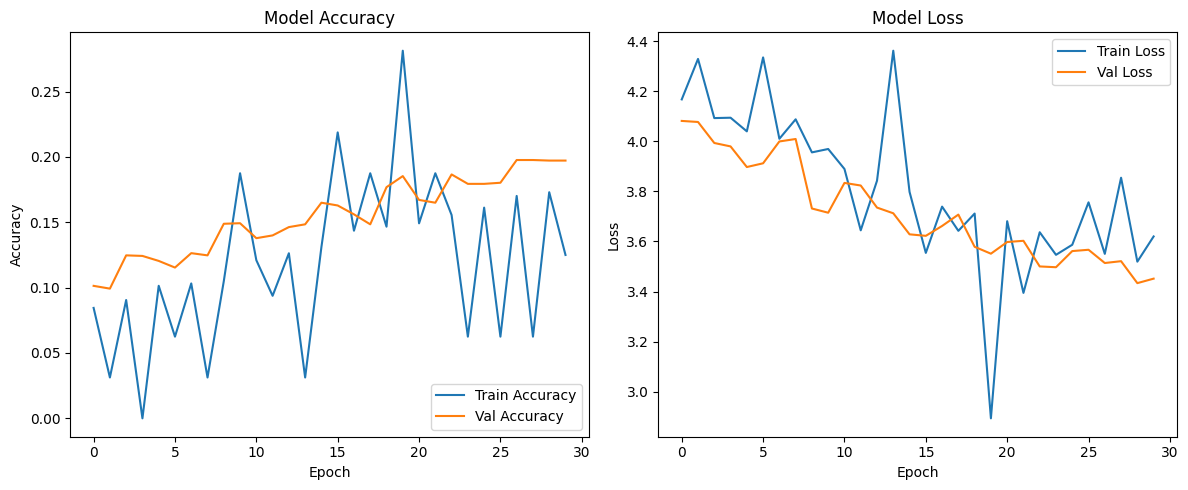

In [2]:
import matplotlib.pyplot as plt

history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()